# SinGAN: Learning a Generative Model from a Single Natural Image

## Preliminaries

We provide you a GUI to set your personal experiment: you are free to select a framework, a task and an image that you want to use as a starting example.

For the image, please refer to one of these three we show you below:
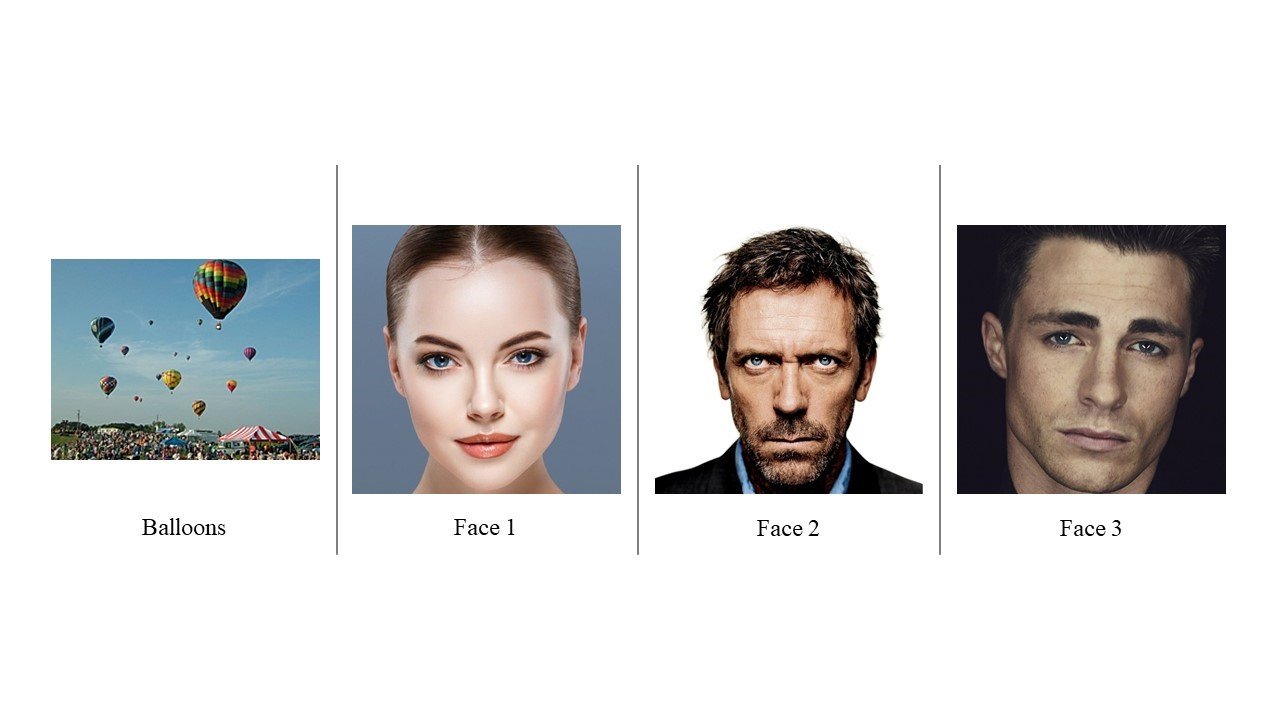

In [1]:
#@title Environment configuration { run: "auto" }

#@markdown Please, set the desired configuration to run your experiments:
environment = "Colab" #@param ["Colab", "Jupyter"]
task = "face_inpainting" #@param ["random_samples", "face_inpainting"]
image = "face3" #@param ["balloons", "face1", "face2", "face3"]
image_size = 512 #@param {type:"integer"}
mode = "train+test" #@param ["train", "test", "train+test"]
n_scales = 8 #@param {type:"integer"}
n_iters = 2000 #@param {type:"integer"}
min_size = 25 #@param {type:"integer"}
max_size = "250" #@param ["250", "365", "480"]
scale_attr = "0.6" #@param ["0.75", "0.6", "0.55", "0.5"]

max_size = int(max_size)
scale_attr = float(scale_attr)

lr = 5e-4 #@param ["5e-4", "2e-4", "1e-4"]
n_samples = 5 #@param {type:"integer"}
inject_scale = 0 #@param {type:"integer"}
kernel_size = 3 #@param {type:"integer"}
stride = 1 #@param {type:"integer"}
padding = "valid" #@param ["valid", "same"]


img_path = 'data/' + str(image)
img_path += '.jpg' if image.find('face') > -1 else '.png'
do_train = True if mode.find('train') > -1 else False
do_test = True if mode.find('test') > -1 else False

In [2]:
if environment == 'Colab':
    
    from google.colab import drive
    drive.mount('/content/drive/')
    
    ! rm -rf sample_data

    save_path = '/content/drive/MyDrive/Colab Notebooks/VP/project/'
    ! cp '/content/drive/MyDrive/Colab Notebooks/VP/project/data.zip' /content/
    ! unzip -q data.zip
    ! rm -rf data.zip

elif environment == 'Jupyter':
    save_path = ''

else:
    raise Exception('invalid environment')

save_path += 'models/' + str(image) + '/'
save_path += str(max_size) + '/' if image.find('face') > -1 else None
print(save_path)

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/VP/project/models/face3/250/


### Library imports

In [3]:
# load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import datetime

# set seeds to guarantee repeatability
np.random.seed(0)
tf.random.set_seed(0)

### Experiment summary

This is the full visualization of the experiment we are going to perform, accordingly to the desired configuration of the user above.

***Experiment configuration***
Task: face_inpainting
Modalities: train: True , test: True
Execution will run on GPU
Selected image:


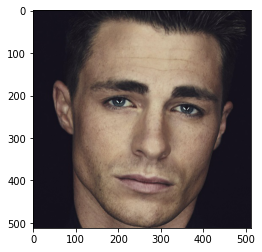

In [4]:
print('***Experiment configuration***')
print('Task:', task)
print('Modalities: train:', do_train, ', test:', do_test)
device = 'GPU' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else 'cpu'
print('Execution will run on', device)
print('Selected image:')

def load_image(img):  
    try:
        imx = Image.open(img)
        return np.array(imx)
        # else
    except IOError:
        return []

img =  load_image(img_path)

plt.figure()
plt.imshow(img)
plt.show()

## SinGAN model

We will follow a 'bottom-up' approach to build the model: starting from its basic components, we will then move to the main parts of the whole architecture. 

In [5]:
class instance_norm(tf.keras.layers.Layer):
    def __init__(self, eps=1e-8):
        super(instance_norm, self).__init__()
        self.eps = eps

    def build(self, shape):
        self.beta = tf.Variable(tf.zeros([shape[3]]))
        self.gamma = tf.Variable(tf.ones([shape[3]]))

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        x = tf.divide(tf.subtract(x, mean), tf.sqrt(tf.add(variance, self.eps)))
        return self.gamma * x + self.beta

# basic convolutional layer
class ConvLayer(tf.keras.layers.Layer):
    def __init__(self,
               n_filters: int,
               kernel_size: int,
               stride: int,
               padding: str):
        super(ConvLayer, self).__init__()

        self.conv = tf.keras.layers.Conv2D(filters=n_filters,
                                           kernel_size=kernel_size,
                                           strides=stride,
                                           padding=padding,
                                           use_bias=False,
                                           kernel_initializer=tf.random_normal_initializer(0, 0.02))

        self.instance_norm = instance_norm()

    def call(self, x):
        x = self.conv(x)
        x = self.instance_norm(x)
        x = tf.keras.layers.LeakyReLU()(x)
        return x

# now we move to greater architectures: generator and discriminator
class Generator(tf.keras.models.Model):
    def __init__(self,
                 n_filters: int,
                 kernel_size: int,
                 stride: int,
                 padding: str):
        super(Generator, self).__init__()

        self.conv1 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv2 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv3 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv4 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv_output = tf.keras.layers.Conv2D(filters=3,
                                                  kernel_size=kernel_size,
                                                  strides=stride,
                                                  padding=padding,
                                                  activation='tanh',
                                                  kernel_initializer=tf.random_normal_initializer(0, 0.02))

        self.padding = tf.keras.layers.ZeroPadding2D(5)

    def call(self, prev, noise):
        x = tf.keras.layers.Add()([self.padding(prev), self.padding(noise)])
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv_output(x)
        x = tf.keras.layers.Add()([x, prev])
        return x

# the discriminator is very similar but here we do NOT pad
class Discriminator(tf.keras.models.Model):
    def __init__(self,
                 n_filters: int,
                 kernel_size: int,
                 stride: int,
                 padding: str):
        super(Discriminator, self).__init__()

        self.conv1 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv2 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv3 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv4 = ConvLayer(n_filters,
                               kernel_size,
                               stride,
                               padding)
        self.conv_output = tf.keras.layers.Conv2D(filters=1,
                                                  kernel_size=kernel_size,
                                                  strides=stride,
                                                  padding=padding,
                                                  kernel_initializer=tf.random_normal_initializer(0, 0.02))

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv_output(x)
        return x

In [6]:
# and now we merge everything into a huge SinGAN
class SinGAN: 
    def __init__(self,
                 n_scales: int,
                 n_iters: int,
                 min_size: int,
                 max_size: int,
                 scale: int,
                 lr: float,
                 kernel_size: int,
                 stride: int,
                 padding: str,
                 n_samples: int,
                 inject_scale: int,
                 task: str,
                 save_dir: str):
        # common params
        self.scale = scale
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # only for training
        self.n_scales = n_scales
        self.n_iters = n_iters
        self.min_size = min_size
        self.max_size = max_size
        self.lr = lr

        # only for testing
        self.n_samples = n_samples
        self.inject_scale = inject_scale
        self.task = task

        self.n_filters = [32*pow(2, (scale//4)) for scale in range(self.n_scales)]

        # we need two paths for saving both the Generator and the Discriminator
        self.save_dir = save_dir
        self.save_dir_gen = save_dir + '/generator'
        self.save_dir_dis = save_dir + '/discriminator'

        self.schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr,
                                                                       decay_steps=4800,
                                                                       decay_rate=0.1,
                                                                       staircase=True)
        
        # initialize useful fields to keep track of the trtaining with TensorBoard
        self.summary_writer = tf.summary.create_file_writer(save_path + 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        self.dis_metric = tf.keras.metrics.Mean()
        self.gen_metric = tf.keras.metrics.Mean()
        self.rec_metric = tf.keras.metrics.Mean()
        
        self.noises = []

        # here the real work is done
        self.build_model()

    def build_model(self):
        # instantiating a list of generators/discriminators for the number of scales
        self.generators = [Generator(n_filters=self.n_filters[s],
                                     kernel_size=self.kernel_size,
                                     stride=self.stride,
                                     padding=self.padding) for s in range(self.n_scales)]

        self.discriminators = [Discriminator(n_filters=self.n_filters[s],
                                             kernel_size=self.kernel_size,
                                             stride=self.stride,
                                             padding=self.padding) for s in range(self.n_scales)]
    
    def train(self, img_path):
        noise = tf.constant(0.1)
        zs_fixed = []

        # first recasting the image to a tf.Tensor
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.cast(img, tf.float32)
        # and resizing to (max_size x max_size)
        img = tf.image.resize(img, 
                              (self.max_size, self.max_size), 
                              method=tf.image.ResizeMethod.BILINEAR,
                              antialias=True,
                              preserve_aspect_ratio=True)
        # we also need to add an additional dimension -> img = (1, max_size, max_size, num_channels=3)
        img = img[tf.newaxis, ...]
        # the last preprocess is a 'normalization':
        # from [0, 255] to [-1, +1]
        img = (img / 127.5) - 1

        # now we build the pyramid: for each level we downsample the image
        pyramid = [img]
        for i in range(1, self.n_scales):
            new_size = (tf.maximum(self.min_size, tf.cast(img.shape[1]*pow(self.scale, i), tf.int32)),
                        tf.maximum(self.min_size, tf.cast(img.shape[2]*pow(self.scale, i), tf.int32)))
            new_level_img = tf.image.resize(img,
                                            size=new_size,
                                            method=tf.image.ResizeMethod.BILINEAR,
                                            antialias=True)
            pyramid.append(new_level_img)
        pyramid.reverse()
        
        # training process
        for scale in range(self.n_scales):
            print('Scale: ' + str(scale))
            start = time.perf_counter()

            # we need to proceed training from the previous model
            if scale > 0 and self.n_filters[scale] == self.n_filters[scale - 1]:
                self.generators[scale].load_weights(self.save_dir_gen + str(scale - 1) + '/generator')
                self.discriminators[scale].load_weights(self.save_dir_dis + str(scale - 1) + '/discriminator')

            # optimizers for the networks
            optimizer_gen = tf.keras.optimizers.Adam(self.lr)
            optimizer_dis = tf.keras.optimizers.Adam(self.lr)

            # simple initialization with zeros
            prev_rec = tf.zeros_like(pyramid[scale])
            self.discriminators[scale](prev_rec)
            self.generators[scale](prev_rec, prev_rec)

            for iter in range(self.n_iters):
                if (iter%200==0 and iter != 0):
                    print('We are at iteration: ' + str(iter))
                # we perform a single training step
                z_rand = tf.random.normal(pyramid[scale].shape)
                z_rec = tf.random.normal(pyramid[scale].shape) if scale == 0 else tf.zeros_like(pyramid[scale])
                
                for i in range(6):
                    if i == 0 and tf.equal(iter, 0):
                        if scale == 0:
                            prev_rand = tf.zeros_like(pyramid[scale])
                            prev_rec = tf.zeros_like(pyramid[scale])
                            noise = 1.0
                        else:
                            fake = tf.zeros_like(pyramid[0])
                            for j in range(scale):
                                z_random = self.noises[j] * tf.random.normal(pyramid[j].shape)
                                fake = self.generators[j](fake, z_random)
                                fake = tf.image.resize(fake,
                                                       (pyramid[j+1].shape[1], pyramid[j+1].shape[2]),
                                                       method=tf.image.ResizeMethod.BILINEAR,
                                                       antialias=True)
                            prev_rand = fake
                            fake = tf.zeros_like(pyramid[0])
                            for j in range(scale):
                                z_fixed = self.noises[j] * zs_fixed[j]
                                fake = self.generators[j](fake, z_fixed)
                                fake = tf.image.resize(fake,
                                                       (pyramid[j+1].shape[1], pyramid[j+1].shape[2]),
                                                       method=tf.image.ResizeMethod.BILINEAR,
                                                       antialias=True)
                            prev_rec = fake

                            # compute RMSE
                            rmse = tf.sqrt(tf.reduce_mean(tf.square(pyramid[scale] - prev_rec)))
                            noise = 0.1 * rmse
                    else:
                        fake = tf.zeros_like(pyramid[0])
                        if (scale > 0):
                            for j in range(scale):
                                z_random = self.noises[j] * tf.random.normal(pyramid[j].shape)
                                fake = self.generators[j](fake, z_random)
                                fake = tf.image.resize(fake,
                                                       (pyramid[j+1].shape[1], pyramid[j+1].shape[2]),
                                                       method=tf.image.ResizeMethod.BILINEAR,
                                                       antialias=True)
                        prev_rand = fake
                           
                    Z_rand = z_rand if scale == 0 else noise * z_rand
                    Z_rec = noise * z_rec
                    
                    if i < 3:
                        with tf.GradientTape() as tape:
                            fake_rand = self.generators[scale](prev_rand, Z_rand)

                            dis_loss = tf.reduce_mean(self.discriminators[scale](fake_rand)) - tf.reduce_mean(self.discriminators[scale](pyramid[scale]))
                            alpha = tf.random.uniform(shape=[1,1,1,1], minval=0., maxval=1.)
                            # interpolating
                            inter = alpha * pyramid[scale] + (1 - alpha) * fake_rand

                            with tf.GradientTape() as tape2:
                                tape2.watch(inter)
                                dis_inter = self.discriminators[scale](inter)
                            gradients = tape2.gradient(dis_inter, [inter])[0]

                            slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[3]))
                            gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)

                            dis_loss = dis_loss + 0.1 * gradient_penalty

                        dis_gradients = tape.gradient(dis_loss, self.discriminators[scale].trainable_variables)
                        optimizer_dis.apply_gradients(zip(dis_gradients, self.discriminators[scale].trainable_variables))

                    else:
                        with tf.GradientTape() as tape:
                            fake_rand = self.generators[scale](prev_rand, Z_rand)
                            fake_rec = self.generators[scale](prev_rec, Z_rec)

                            gen_loss = -tf.reduce_mean(self.discriminators[scale](fake_rand))
                            # reconstruction loss
                            rec_loss = tf.reduce_mean(tf.square(fake_rec - pyramid[scale]))
                            gen_loss = gen_loss + 10 * rec_loss

                        gen_gradients = tape.gradient(gen_loss, self.generators[scale].trainable_variables)
                        optimizer_gen.apply_gradients(zip(gen_gradients, self.generators[scale].trainable_variables)) 

                metrics = (dis_loss, gen_loss, rec_loss)

                z_fixed = z_rec
                #return z_rec, prev_rec, noise_amp, metrics

            zs_fixed.append(z_fixed)
            self.noises.append(noise)

            # saving models
            dir_gen = self.save_dir_gen + str(scale)
            dir_dis = self.save_dir_dis + str(scale)
            if not os.path.exists(dir_gen):
                os.makedirs(dir_gen)
            if not os.path.exists(dir_dis):
                os.makedirs(dir_dis)

            # save the weights of the current pair of generator and discriminator
            self.generators[scale].save_weights(dir_gen + '/generator', save_format='tf')
            self.discriminators[scale].save_weights(dir_dis + '/discriminator', save_format='tf')
            # but also remember to save the noise
            np.save(self.save_dir + '/noises', self.noises)


            dis_loss, gen_loss, rec_loss = metrics
            
            with self.summary_writer.as_default():
                tf.summary.scalar('dis_loss', dis_loss, step=scale)
                tf.summary.scalar('gen_loss', gen_loss, step=scale)
                tf.summary.scalar('rec_loss', rec_loss, step=scale)
                
            self.dis_metric(dis_loss)
            self.gen_metric(gen_loss)
            self.rec_metric(rec_loss)
            
            print(f' dis_loss = {self.dis_metric.result():.3f}')
            print(f' gen_loss = {self.gen_metric.result():.3f}')
            print(f' rec_loss = {self.rec_metric.result():.3f}')

            # reset metrics every epoch (aka every scale)
            self.dis_metric.reset_states()
            self.gen_metric.reset_states()
            self.rec_metric.reset_states()
            
            print(f'Time taken for scale {scale} is {time.perf_counter()-start:.2f} sec\n')

    def test(self, img_path, masked_path=None):
        # refresh the generators list and load the pretrained weights
        self.generators = []
        #load the self.noises list and generators obtained from the training
        for path, dirs, _ in os.walk(self.save_dir):
            dirs.sort()
            for dir in dirs:
                net = dir[0:-1]
                scale = int(dir[-1]) if net == 'generator' else None # 'if' for testing balloons
                if net == 'generator':
                    #print(scale)
                    generator = Generator(n_filters=32*pow(2, (scale//4)),
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=padding)
                    generator.load_weights(path+dir+'/generator').expect_partial()

                    self.generators.append(generator)

        self.noises = np.load(self.save_dir + 'noises.npy')
        
        
        # first recasting the image to a tf.Tensor
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.cast(img, tf.float32)
        prop = self.max_size/tf.shape(img)[0].numpy()
        # and resizing to (max_size x max_size)
        img = tf.image.resize(img, (self.max_size, int(tf.shape(img)[1].numpy()*prop)))
        # we also need to add an additional dimension -> img = (1, max_size, max_size, num_channels=3)
        img = img[tf.newaxis, ...]
        # the last preprocess is a 'normalization':
        # from [0, 255] to [-1, +1]
        img = (img / 127.5) - 1

        # now we build the pyramid: for each level we downsample the image
        pyramid = [img]
        for i in range(1, self.n_scales):
            new_size = (tf.maximum(self.min_size, tf.cast(img.shape[1]*pow(self.scale, i), tf.int32)),
                        tf.maximum(self.min_size, tf.cast(img.shape[2]*pow(self.scale, i), tf.int32)))
            new_level_img = tf.image.resize(img,
                                            size=new_size)
            pyramid.append(new_level_img)

        pyramid.reverse()

        if self.task == 'random_samples':
            z_fixed = tf.random.normal(pyramid[0].shape)
            for sample in range(self.n_samples):
                fake = tf.zeros_like(pyramid[0])

                for scale, generator in enumerate(self.generators):
                    
                    fake = tf.image.resize(fake,
                                          (pyramid[scale].shape[1], pyramid[scale].shape[2]),
                                           method=tf.image.ResizeMethod.BILINEAR,
                                           antialias=True)
                    
                    z = tf.random.normal(fake.shape)
                    z = z * self.noises[scale]

                    fake = generator(fake, z)

                # routine to plot:
                # 1) 'denormalization'
                to_plot = (fake + 1) * 127.5
                # 2) clipping to 0 and 255
                to_plot = tf.clip_by_value(to_plot, 0.0, 255.0)
                # 3) reconversion to numpy array and truncate of the 1st dimention (i.e. batch size)
                to_plot = Image.fromarray(np.array(to_plot).astype(np.uint8).squeeze())
                #to_plot.save("/content/drive/MyDrive/Colab Notebooks/VP/project/results/random_samples/face3/480/result"+str(sample+1)+".jpg")
                plt.figure()
                plt.title('Random Samples ' + str(sample))
                plt.imshow(to_plot)
                plt.show()

        elif self.task == 'face_inpainting':
            # in face inpainting we build another pyramid with the masked face exactly as before:
            # first recasting the image to a tf.Tensor
            img = tf.io.read_file(masked_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.cast(img, tf.float32)
            prop = self.max_size/tf.shape(img)[0].numpy()
            # and resizing to (max_size x max_size)
            img = tf.image.resize(img, (self.max_size, int(tf.shape(img)[1].numpy()*prop)))
            
            inpainted_img = img
            
            # we also need to add an additional dimension -> img = (1, max_size, max_size, num_channels=3)
            img = img[tf.newaxis, ...]
            # the last preprocess is a 'normalization':
            # from [0, 255] to [-1, +1]
            img = (img / 127.5) - 1

            # now we build the pyramid: for each level we downsample the image
            masked_pyramid = [img]
            for i in range(1, self.n_scales):
                new_size = (tf.maximum(self.min_size, tf.cast(img.shape[1]*pow(self.scale, i), tf.int32)),
                            tf.maximum(self.min_size, tf.cast(img.shape[2]*pow(self.scale, i), tf.int32)))
                new_level_img = tf.image.resize(img,
                                                size=new_size)
                masked_pyramid.append(new_level_img)

            masked_pyramid.reverse()
            
            plt.figure(figsize=(6.4*5, 6.4*5))
            
            plt.subplot(151), plt.imshow(load_image(img_path)), plt.title('Original image')
            plt.subplot(152), plt.imshow(load_image(masked_path)), plt.title('Masked image')
            
            
            z_fixed = tf.random.normal(masked_pyramid[0].shape)
            
            for sample in range(3):
                fake = tf.zeros_like(masked_pyramid[0])

                for scale, generator in enumerate(self.generators):
                    
                    fake = tf.image.resize(fake,
                                          (masked_pyramid[scale].shape[1], masked_pyramid[scale].shape[2]),
                                           method=tf.image.ResizeMethod.BILINEAR,
                                           antialias=True)
                    
                    z = tf.random.normal(fake.shape)
                    z = z * self.noises[scale]

                    fake = generator(fake, z)
                
                # routine to plot:
                # 1) 'denormalization'
                fake = (fake + 1) * 127.5
                # 2) clipping to 0 and 255
                fake = tf.clip_by_value(fake, 0.0, 255.0)
                # 3) reconversion to numpy array and truncate of the 1st dimention (i.e. batch size)
                fake = Image.fromarray(np.array(fake).astype(np.uint8).squeeze())
                
                crop = fake.crop((75, 75, 175, 175))
                inpainted_img = Image.fromarray(np.array(inpainted_img).astype(np.uint8).squeeze())
                inpainted_img.paste(crop, (75, 75, 175, 175))

                #inpainted_img.save("results/face_inpainting/face2/result"+str(sample+1)+".jpg")
                
                plt.subplot(153+sample), plt.imshow(inpainted_img), plt.title('Face Inpainting Samples ' + str(sample+1))
                
            plt.show()

        else:
            raise Exception('Unexpected task')

Okay, now we have our full model composed by a set of Generators and Discriminators that will act at different scale on the (resized) image.

In [7]:
model = SinGAN(n_scales=n_scales,
               n_iters=n_iters,
               min_size=min_size,
               max_size=max_size,
               scale=scale_attr,
               lr=lr,
               kernel_size=kernel_size,
               stride=stride,
               padding=padding,
               n_samples=n_samples,
               inject_scale=inject_scale,
               task=task,
               save_dir=save_path)

## Experiment

### Training phase

Let's proceed with the experiment: here we perform training and/or testing, according to the desired configuration of the user above.

If training, we will monitor the involved losses both with sequential prints and with the **TensorBoard** GUI just below.

In [ ]:
if do_train:
    print('Starting training...')
    model.train(img_path)
    print('Training completed')
else:
    print('No train for the desired configuration')

No train for the desired configuration


In [ ]:
if do_train:
    if environment == 'Colab':
        %tensorboard --logdir='/content/drive/MyDrive/Colab Notebooks/VP/project/models/face3/250/log/fit'
    #elif environment == 'Jupyter':
    #    %tensorboard --logdir='log/fit'

### Evaluation

While if testing, we show the evolution of the 'fake' image created by the generators at different scales.

We will first replicate the results from the original paper by providing realistic random generations from the 'balloons' image and then we will move to our extension about face generation.

#### Original paper: random generation of balloons

Loading weights from/content/drive/MyDrive/Colab Notebooks/VP/project/models/random_samples/balloons/
Starting testing...


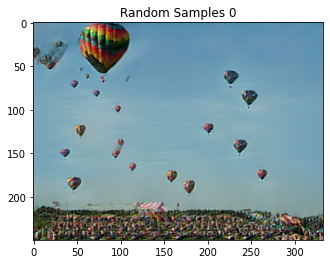

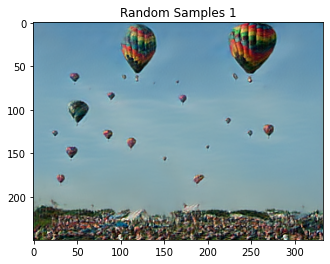

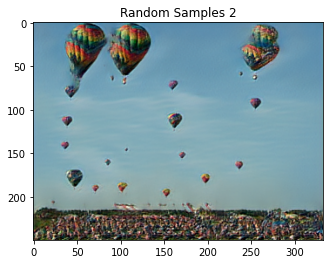

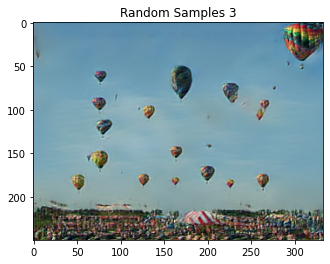

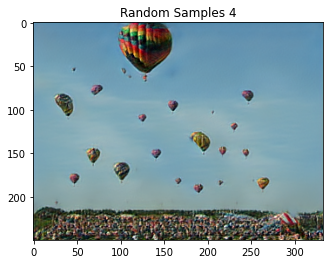

Testing completed


In [ ]:
# max_size 250
# 2000_25_0.75
# balloons.png

model = SinGAN(n_scales=n_scales,
               n_iters=n_iters,
               min_size=min_size,
               max_size=max_size,
               scale=scale_attr,
               lr=lr,
               kernel_size=kernel_size,
               stride=stride,
               padding=padding,
               n_samples=n_samples,
               inject_scale=inject_scale,
               task=task,
               save_dir=save_path)

print('Loading weights from' + save_path)

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

#### Our extension: trying with the extreme case of faces

Starting testing...


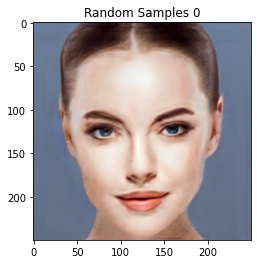

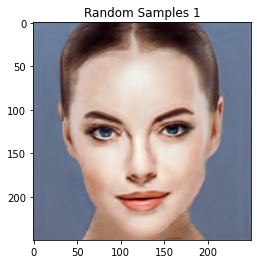

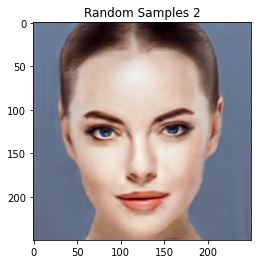

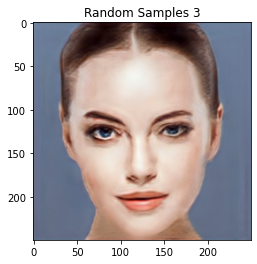

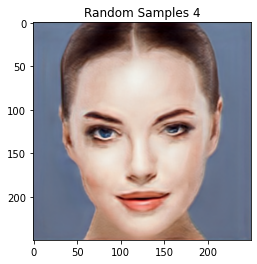

Testing completed


In [ ]:
'''
FACE TESTING:
respectively n_iters-min_size-scale_attr

original: 2000_25_0.75 --> bad
test: 2000_25_0.6 --> good
test: 1000_25_0.6 --> good, less than 2000
test: 2000_15_0.6 --> bad, still better than 0.75
test: 2000_40_0.6 --> bad

test: 2000_25_0.5 --> good+
test: 2000_25_0.4 --> good++, ma la bocca (posizione denti) cambia molto poco

test: 4000_25_0.45 --> no visible improvements

best result => 2000_25_0.5
'''


# face1.jpg
# max_size 250
# 2000_25_0.6

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


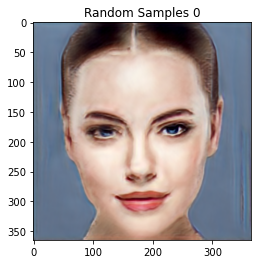

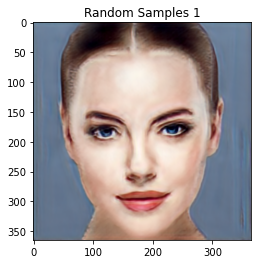

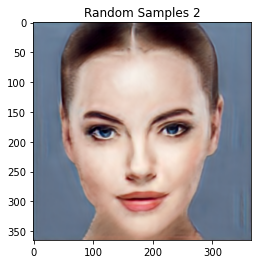

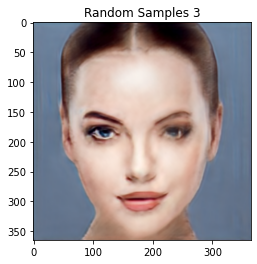

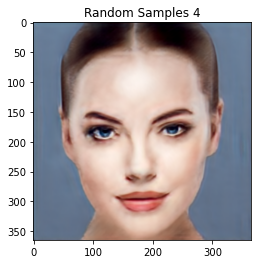

Testing completed


In [ ]:
# face1.jpg
# max_size 365
# 2000_25_0.55

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


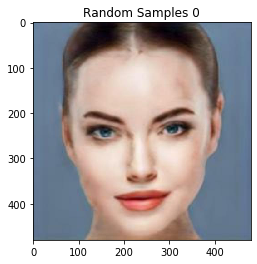

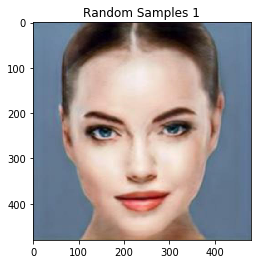

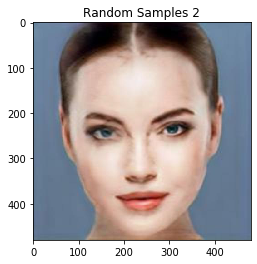

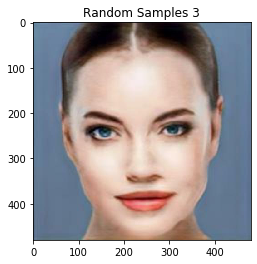

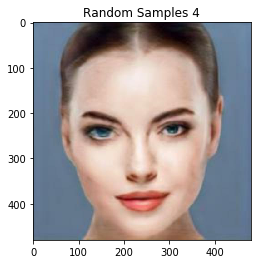

Testing completed


In [ ]:
# face1.jpg
# max_size 480
# 2000_25_0.5

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


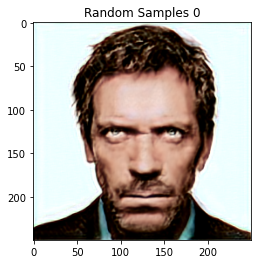

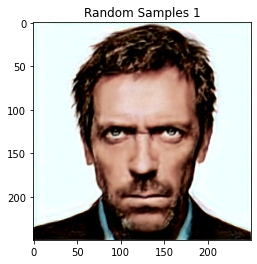

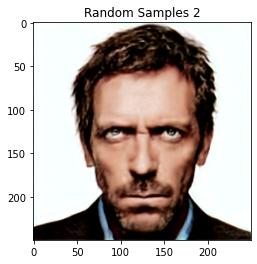

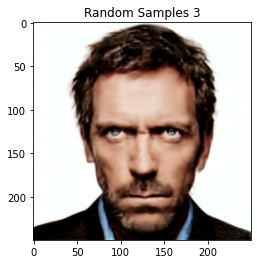

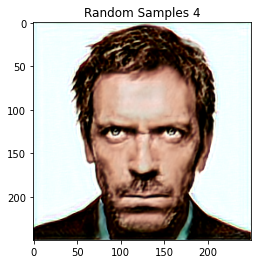

Testing completed


In [ ]:
# face2.jpg
# max_size 250
# 2000_25_0.6

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


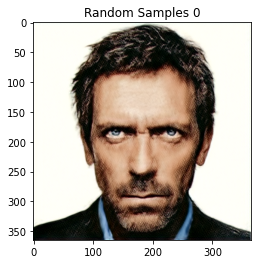

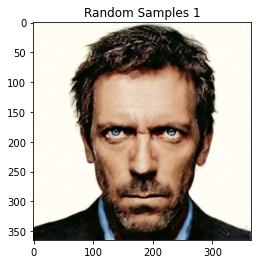

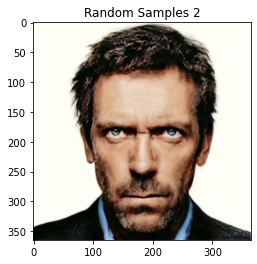

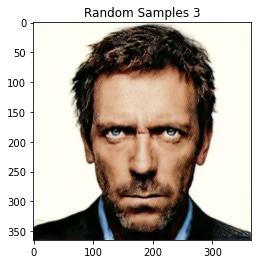

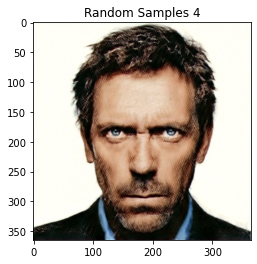

Testing completed


In [ ]:
# face2.jpg
# max_size 365
# 2000_25_0.55

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


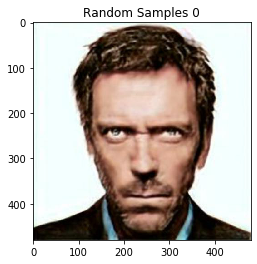

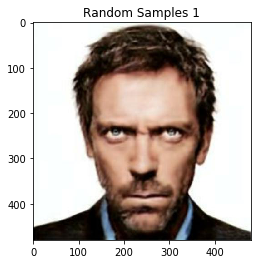

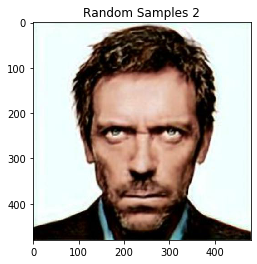

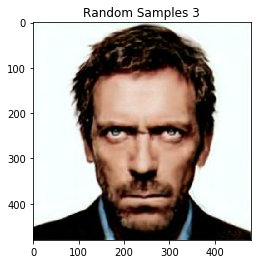

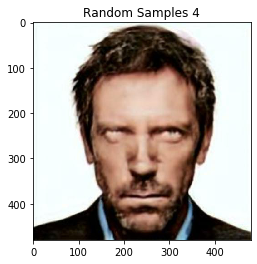

Testing completed


In [ ]:
# face2.jpg
# max_size 480
# 2000_25_0.5

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


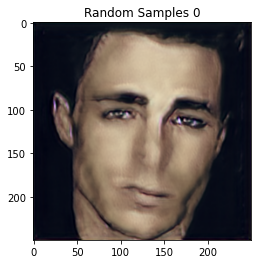

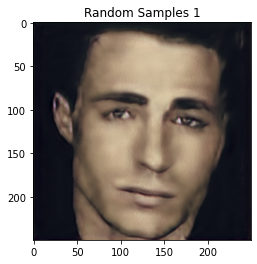

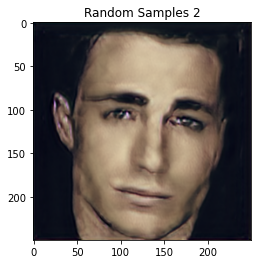

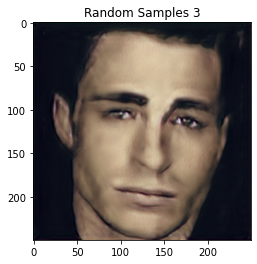

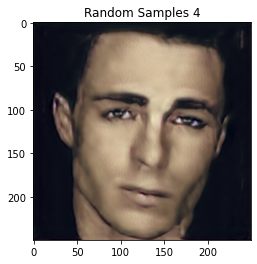

Testing completed


In [ ]:
# face3.jpg
# max_size 250
# 2000_25_0.6

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


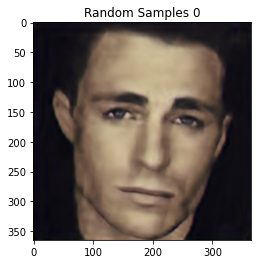

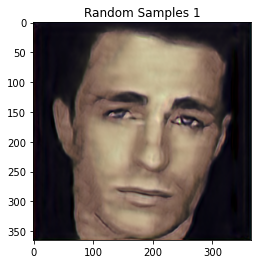

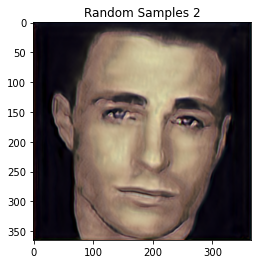

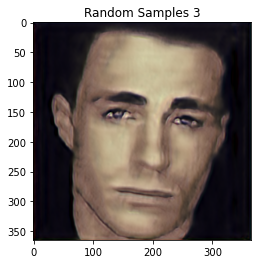

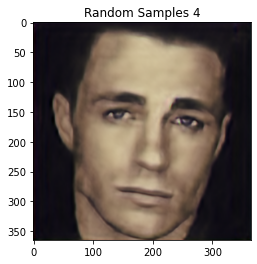

Testing completed


In [ ]:
# face3.jpg
# max_size 365
# 2000_25_0.55

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

Starting testing...


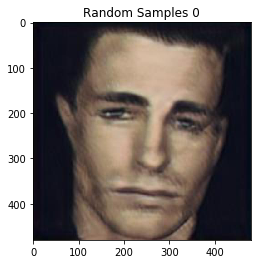

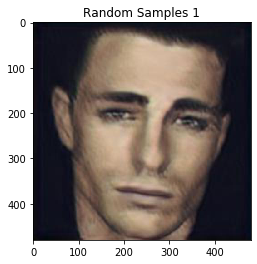

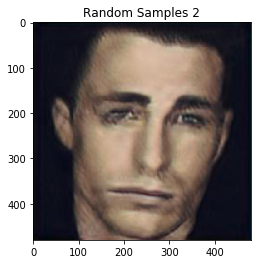

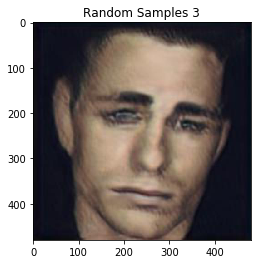

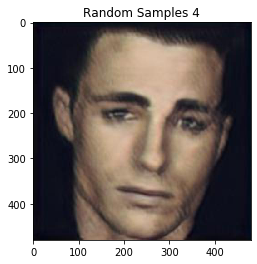

Testing completed


In [ ]:
# face3.jpg
# max_size 480
# 2000_25_0.5

if do_test:
    print('Starting testing...')
    model.test(img_path)
    print('Testing completed')

### Proceeding in our work: SinGAN for Face Inpainting

We have also tested SinGAN for Face Inpainintg. However, this task is not performed in the traditional way: in fact, the model is not trained on 'masked' images and does not compare them with the original ones to improve itself. Our SinGAN (only at testing time) simply tries to fill the masked area of the face to realize almost realistic inpainted pictures.

We have used this application to monitor and test the model on a different task and analyse the related results to understand the 'strenghts' of the model we have created.

In [ ]:
model = SinGAN(n_scales=n_scales,
               n_iters=n_iters,
               min_size=min_size,
               max_size=max_size,
               scale=scale_attr,
               lr=lr,
               kernel_size=kernel_size,
               stride=stride,
               padding=padding,
               n_samples=n_samples,
               inject_scale=inject_scale,
               task=task,
               save_dir=save_path)

if task == 'face_inpainting':
    masked_path = 'results/face_inpainting/'+str(image)+'/'+str(image)+'_masked.jpg'
    
masked_path

'results/face_inpainting/face3/face3_masked.jpg'

Let's visualize the results for each of the three faces we have tested so far.

Starting testing...


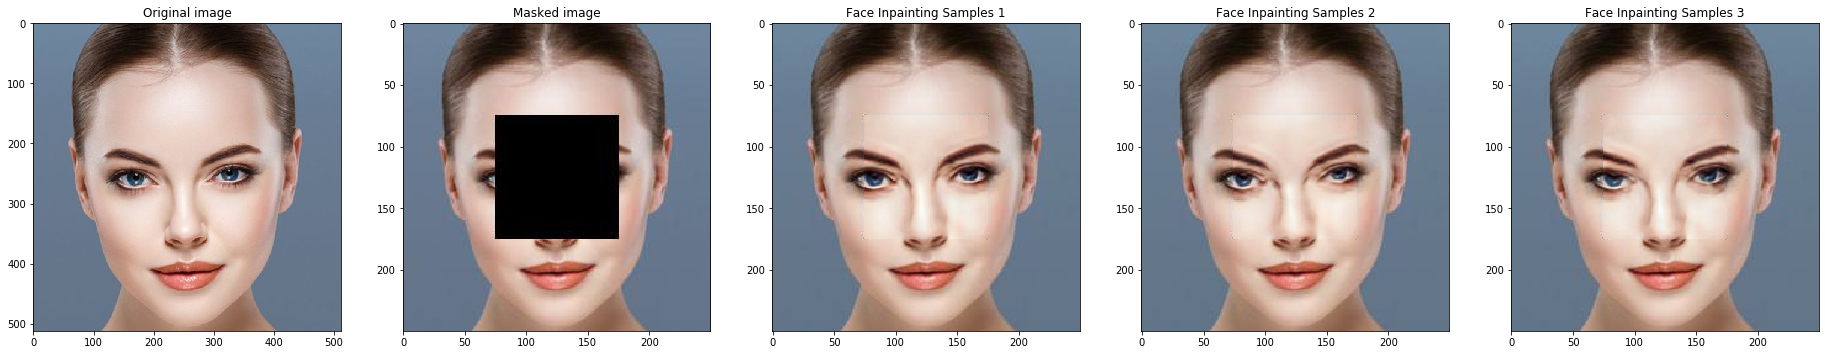

Testing completed


In [ ]:
if do_test:
    print('Starting testing...')
    model.test(img_path, masked_path)
    print('Testing completed')

Starting testing...


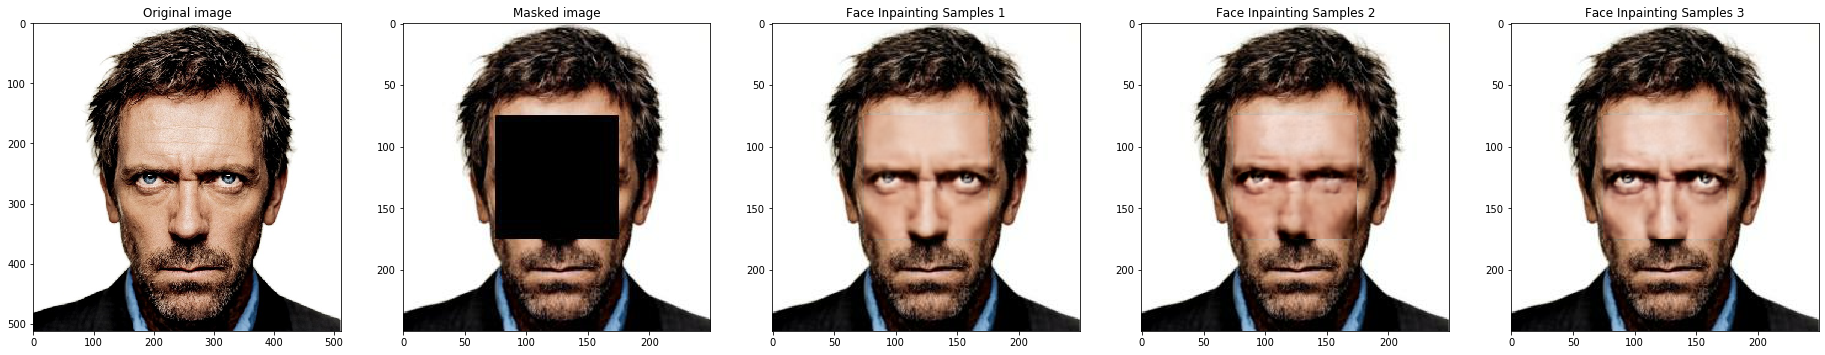

Testing completed


In [ ]:
if do_test:
    print('Starting testing...')
    model.test(img_path, masked_path)
    print('Testing completed')

Starting testing...


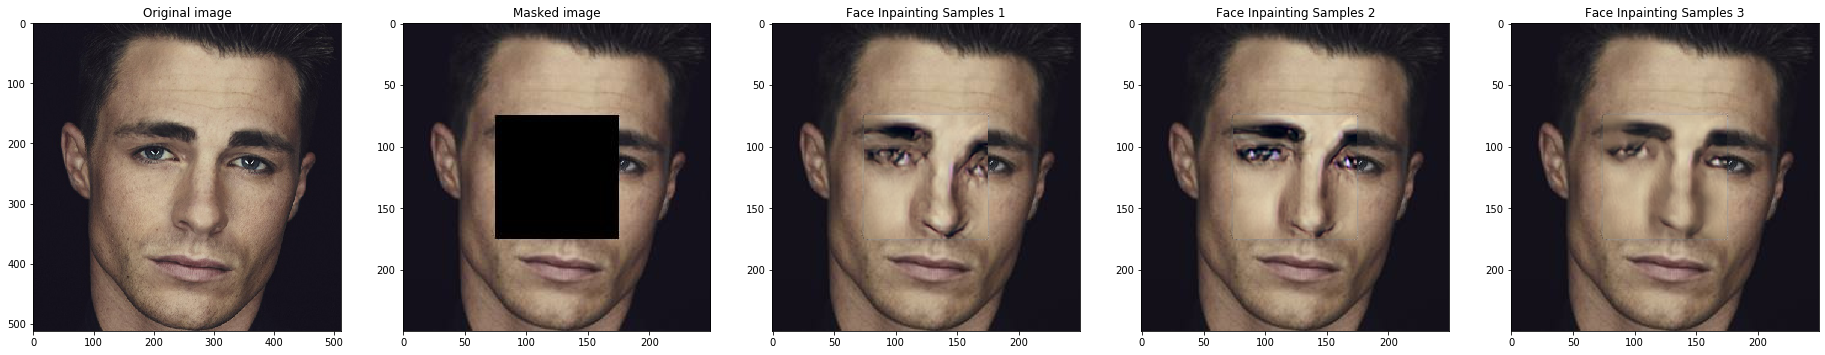

Testing completed


In [ ]:
if do_test:
    print('Starting testing...')
    model.test(img_path, masked_path)
    print('Testing completed')